In [57]:
# Define the environment
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO, A2C, DQN
from sb3_contrib import TRPO

# Define the market environment
class MarketEnvironment(gym.Env):
    def __init__(self):
        super(MarketEnvironment, self).__init__()

        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions, Box(2,) for two sellers
        self.action_space = spaces.MultiDiscrete([101, 101])

        # Prices could range from 0 to 100, there are four buyers
        self.observation_space = spaces.Box(low=0, high=100, shape=(6,))
        self.prices_history = []


        # Initialize state
        self.reset()

    def step(self, action):
        # Execute one time step within the environment
        assert self.action_space.contains(action)

        # Simple model: buyers buy from the cheapest seller
        sorted_sellers = np.argsort(action)
        self.state[0] = action[sorted_sellers[0]]
        self.state[1] = action[sorted_sellers[1]]

        # Distribute the buyers
        for i in range(2, 6):
            if self.state[i] >= self.state[0]:
                self.state[0] += self.state[i]
                self.state[i] = 0
            elif self.state[i] >= self.state[1]:
                self.state[1] += self.state[i]
                self.state[i] = 0

        # Set reward as the profit of the sellers
        reward = self.state[0] + self.state[1]

        # Set done flag if all buyers have bought the products
        done = np.sum(self.state[2:]) == 0

        # Save the prices to history
        self.prices_history.append(action)

        return self.state, reward, done, {}


    def reset(self):
        # Reset the state of the environment to an initial state
        self.state = np.zeros(6)
        # Initialize buyers' willingness to pay
        self.state[2:6] = np.random.uniform(low=0, high=100, size=4)
        return self.state

# Initialize environment
env = MarketEnvironment()

# Initialize reinforcement learning agents
model1 = PPO("MlpPolicy", env, verbose=1)
model2 = TRPO("MlpPolicy", env, verbose=1)
# Train agents
model1.learn(total_timesteps=20000)
model2.learn(total_timesteps=20000)



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.5     |
|    ep_rew_mean     | 1.44e+03 |
| time/              |          |
|    fps             | 905      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 13.6         |
|    ep_rew_mean          | 1.57e+03     |
| time/                   |              |
|    fps                  | 759          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0017358052

In [69]:
def evaluate_model(model, env, num_episodes=1):
    episode_rewards = []
    episode_actions = []
    for i in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        actions = []
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            actions.append(action)
        episode_rewards.append(episode_reward)
        episode_actions.append(actions)
    return np.mean(episode_rewards), episode_actions

# Evaluate the first agent
mean_reward1, actions1 = evaluate_model(model1, env)
print(f"Mean reward for the first agent: {mean_reward1}")

# Evaluate the second agent
mean_reward2, actions2 = evaluate_model(model2, env)
print(f"Mean reward for the second agent: {mean_reward2}")


Mean reward for the first agent: 2134.5048029310337
Mean reward for the second agent: 3837.219356862956


In [73]:
actions1

[[array([45, 59]),
  array([94, 34]),
  array([75, 66]),
  array([86, 22]),
  array([43, 31]),
  array([49, 55]),
  array([64, 26]),
  array([61, 40]),
  array([86, 39]),
  array([46, 75]),
  array([54, 51]),
  array([67, 33]),
  array([16, 92]),
  array([42, 48]),
  array([ 8, 51]),
  array([19, 17]),
  array([42,  7]),
  array([71, 81]),
  array([77, 22]),
  array([71,  1])]]

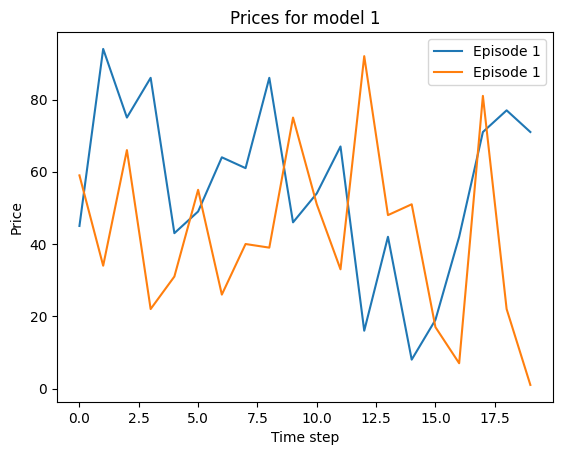

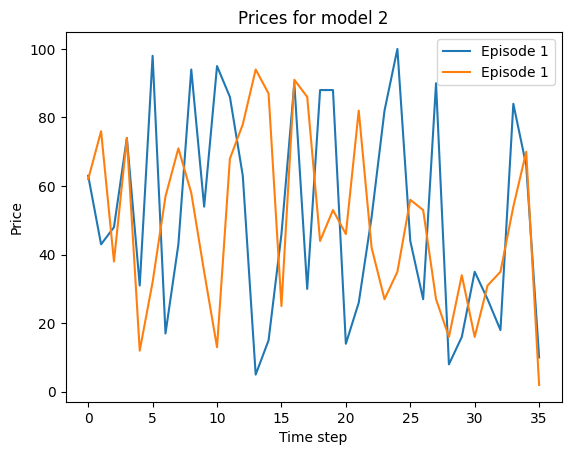

In [75]:
import matplotlib.pyplot as plt

# Plot prices for the first agent
for i, actions in enumerate(actions1):
    plt.plot(actions, label=f'Episode {i+1}')
plt.title('Prices for model 1')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot prices for the second agent
for i, actions in enumerate(actions2):
    plt.plot(actions, label=f'Episode {i+1}')
plt.title('Prices for model 2')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.show()
